Libraries (don't change)

In [3]:
!pip -q install torchinfo
!pip -q install mlflow
!pip install mlflow
import mlflow
import mlflow.pytorch

from dataclasses import dataclass
from typing import List, Callable, Optional, Tuple

import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchinfo import summary

from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
%matplotlib inline


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.2/779.2 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 10.5 MB/s eta 0:00:00


Device (don't change)

In [4]:

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
use_amp = (DEVICE == "cuda")

print(f"Using device: {DEVICE}")
print(f"Mixed precision (AMP): {use_amp}")

Using device: cpu
Mixed precision (AMP): False


Data (don't change)

In [5]:

class DataManager:
    def __init__(self, dataset_class, root: str = "./data", val_fraction: float = 0.1,
                 batch_size: int = 32, seed: int = 42):
        self.dataset_class = dataset_class
        self.root = root
        self.val_fraction = val_fraction
        self.batch_size = batch_size
        self.seed = seed

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1918,), (0.3483,))
        ])

    def get_loaders(self) -> Tuple[DataLoader, DataLoader, DataLoader]:
        full_train = self.dataset_class(root=self.root, train=True,
                                        download=True, transform=self.transform)
        test_ds = self.dataset_class(root=self.root, train=False,
                                     download=True, transform=self.transform)

        val_size = int(len(full_train) * self.val_fraction)
        train_size = len(full_train) - val_size

        generator = torch.Generator().manual_seed(self.seed)
        train_ds, val_ds = random_split(full_train, [train_size, val_size], generator=generator)

        train_loader = DataLoader(train_ds, batch_size=self.batch_size,
                                  shuffle=True, num_workers=2, pin_memory=True)
        val_loader   = DataLoader(val_ds,   batch_size=self.batch_size,
                                  shuffle=False, num_workers=2, pin_memory=True)
        test_loader  = DataLoader(test_ds,  batch_size=self.batch_size,
                                  shuffle=False, num_workers=2, pin_memory=True)

        print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")
        return train_loader, val_loader, test_loader

Configurations (don't change)

In [6]:
import torch.nn as nn

@dataclass
class LayerSpec:
    out_dim: int
    activation: Type[nn.Module] = nn.ReLU # Changed from F.relu to nn.ReLU
    dropout: float = 0.0
    batch_norm: bool = True
    weight_decay: float = 0.0

@dataclass
class ModelConfig:
    input_dim: Tuple[int, int, int] = (1, 28, 28)
    num_classes: int = 10
    layers: List[LayerSpec] = None

@dataclass
class TrainConfig:
    batch_size: int = 64
    epochs: int = 100
    lr: float = 1e-4
    patience: int = 15
    min_delta: float = 1e-4
    val_fraction: float = 0.1
    seed: int = 42

Model

In [7]:

class MLPFromConfig(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()
        flat_dim = config.input_dim[0] * config.input_dim[1] * config.input_dim[2]
        self.layers_specs = config.layers
        layers = []
        prev_dim = flat_dim

        for i, spec in enumerate(config.layers):
            linear = nn.Linear(prev_dim, spec.out_dim)

            layers.append(linear)
            if spec.batch_norm:
                layers.append(nn.BatchNorm1d(spec.out_dim))
            if spec.dropout > 0:
                layers.append(nn.Dropout(spec.dropout))
            layers.append(spec.activation())
            prev_dim = spec.out_dim

        # Final classifier layer
        self.final_linear = nn.Linear(prev_dim, config.num_classes)
        layers.append(self.final_linear)

        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(x.size(0), -1)
        return self.net(x)

    def get_layer_params(self):
        linear_layers = []
        for module in self.net:
            if isinstance(module, nn.Linear):
                linear_layers.append(module)
        return linear_layers

Early Stopping (don't change)

In [8]:

class EarlyStopping:
    def __init__(self, patience: int = 10, min_delta: float = 1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.should_stop = False

    def __call__(self, val_loss: float) -> bool:
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
        return self.should_stop

Trainer (don't change)

In [9]:

class Trainer:
    def __init__(self, model: nn.Module, config: TrainConfig):
        self.model = model.to(DEVICE)
        self.config = config
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = self._build_optimizer()
        self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
        self.early_stopping = EarlyStopping(patience=config.patience,
                                            min_delta=config.min_delta)

        self.history = {"train_loss": [], "train_acc": [],
                        "val_loss": [], "val_acc": []}

    def _build_optimizer(self):

        # Collect all Linear layers in the order they appear
        linear_layers = []
        for name, module in self.model.named_modules():
            if isinstance(module, nn.Linear):
                linear_layers.append((name, module))

        param_groups = []

        for i, spec in enumerate(self.model.layers_specs):
            name, layer = linear_layers[i]
            param_groups.append({
                'params': layer.parameters(),
                'weight_decay': spec.weight_decay
            })

        final_name, final_layer = linear_layers[-1]
        param_groups.append({
            'params': final_layer.parameters(),
            'weight_decay': 0.0
        })

        return torch.optim.SGD(param_groups, momentum=0.9, nesterov=True, lr=self.config.lr)

    def _train_epoch(self, loader: DataLoader):
        self.model.train()
        total_loss = 0.0
        correct = 0
        total = 0

        for data, target in loader:
            data, target = data.to(DEVICE), target.to(DEVICE)

            self.optimizer.zero_grad()
            with torch.cuda.amp.autocast(enabled=use_amp):
                output = self.model(data)
                loss = self.criterion(output, target)

            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()

            total_loss += loss.item() * data.size(0)
            correct += (output.argmax(1) == target).sum().item()
            total += data.size(0)

        return total_loss / total, correct / total

    @torch.no_grad()
    def _eval_epoch(self, loader: DataLoader):
        self.model.eval()
        total_loss = 0.0
        correct = 0
        total = 0

        for data, target in loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            with torch.cuda.amp.autocast(enabled=use_amp):
                output = self.model(data)
                loss = self.criterion(output, target)

            total_loss += loss.item() * data.size(0)
            correct += (output.argmax(1) == target).sum().item()
            total += data.size(0)

        return total_loss / total, correct / total

    def fit(self, train_loader: DataLoader, val_loader: DataLoader):
        print("🚀 Starting training...\n")
        for epoch in range(1, self.config.epochs + 1):
            train_loss, train_acc = self._train_epoch(train_loader)
            val_loss, val_acc     = self._eval_epoch(val_loader)

            self.history["train_loss"].append(train_loss)
            self.history["train_acc"].append(train_acc)
            self.history["val_loss"].append(val_loss)
            self.history["val_acc"].append(val_acc)

            print(f"Epoch {epoch:3d} | "
                  f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

            if self.early_stopping(val_loss):
                print(f"\n🛑 Early stopping triggered at epoch {epoch}")
                break

        print("\n✅ Training complete!")

    @torch.no_grad()
    def evaluate(self, loader: DataLoader):
        return self._eval_epoch(loader)

    @torch.no_grad()
    def predict_all(self, loader: DataLoader):
        self.model.eval()
        all_preds, all_targets = [], []
        for x, y in loader:
            x = x.to(DEVICE, non_blocking=True)
            logits = self.model(x)
            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.append(preds)
            all_targets.append(y.numpy())
        return np.concatenate(all_preds), np.concatenate(all_targets)


    def save(self, path: str = "mlp_best.pt"):
        torch.save(self.model.state_dict(), path)
        print(f"💾 Model saved to {path}")



Run (do change)

In [12]:
import pandas as pd
import os
import torch
import mlflow
from google.colab import drive
from torchvision import datasets
from sklearn.metrics import classification_report

# 1. חיבור ל-Google Drive לשמירה מאובטחת
drive.mount('/content/drive')
backup_file = "/content/drive/MyDrive/kmnist_results.csv"

# 2. טעינת תוצאות קודמות (מאפשר המשכיות במקרה של ניתוק)
if os.path.exists(backup_file):
    results_df = pd.read_csv(backup_file)
    completed_experiments = results_df['experiment'].tolist()
    results = results_df.to_dict('records')
    print(f"🔄 נמצאו {len(completed_experiments)} ניסויים קודמים. ממשיך מהנקודה שבה הפסקנו...")
else:
    results = []
    completed_experiments = []
    print("🆕 מתחיל קובץ תוצאות חדש בדרייב.")

mlflow.set_experiment("KMNIST_MLP")

# הגדרת הפרמטרים לניסויים
neurons_list = [256, 512]
dropout_list = [0.1, 0.2]
lr_list      = [1e-3, 5e-4, 1e-4]
exp_id = 0

# לולאת הניסויים המרכזית
for neurons in neurons_list:
    for dropout in dropout_list:
        for lr in lr_list:
            exp_id += 1

            # דילוג על ניסויים שכבר הושלמו בדרייב
            if exp_id in completed_experiments:
                continue

            print(f"\n" + "="*40)
            print(f"🚀 מריץ ניסוי {exp_id}: Neurons={neurons}, Dropout={dropout}, LR={lr}")
            print("="*40)

            # הגדרות אימון
            train_cfg = TrainConfig(
                batch_size=128,
                epochs=100,
                lr=lr,
                patience=10,
                min_delta=1e-4,
                val_fraction=0.1
            )

            # טעינת נתונים
            data_mgr = DataManager(
                dataset_class=datasets.KMNIST,
                val_fraction=train_cfg.val_fraction,
                batch_size=train_cfg.batch_size,
                seed=train_cfg.seed
            )
            train_loader, val_loader, test_loader = data_mgr.get_loaders()

            # הגדרת המודל (שימוש ב-nn.ReLU למניעת שגיאות)
            model_cfg = ModelConfig(
                layers=[
                    LayerSpec(
                        out_dim=neurons,
                        dropout=dropout,
                        batch_norm=True,
                        activation=nn.ReLU  # חשוב: בלי סוגריים כאן, ה-Model יוסיף אותם
                    )
                ]
            )

            # אתחול ואימון
            model = MLPFromConfig(model_cfg)
            trainer = Trainer(model, train_cfg)

            # הרצת האימון
            trainer.fit(train_loader, val_loader)

            # הערכה על סט הטסט
            test_loss, test_acc = trainer.evaluate(test_loader)
            preds, targets = trainer.predict_all(test_loader)
            report = classification_report(targets, preds, output_dict=True)

            # איסוף תוצאות
            current_res = {
                "experiment": exp_id,
                "neurons": neurons,
                "dropout": dropout,
                "learning_rate": lr,
                "test_accuracy": test_acc,
                "precision_test": report["macro avg"]["precision"],
                "recall_test": report["macro avg"]["recall"],
                "f1_score_test": report["macro avg"]["f1-score"]
            }
            results.append(current_res)

            # שמירה מיידית לדרייב
            pd.DataFrame(results).to_csv(backup_file, index=False)
            print(f"✅ ניסוי {exp_id} נשמר בהצלחה בדרייב!")

print("\n" + "⭐"*30)
print("כל הניסויים הושלמו בהצלחה!")
print(f"הקובץ הסופי מחכה לך בדרייב: {backup_file}")
print("⭐"*30)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🆕 מתחיל קובץ תוצאות חדש בדרייב.

🚀 מריץ ניסוי 1: Neurons=256, Dropout=0.1, LR=0.001
Train: 54000 | Val: 6000 | Test: 10000
🚀 Starting training...



/tmp/ipython-input-2705984033.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-2705984033.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipython-input-2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch   1 | Train Loss: 0.9938 Acc: 0.7263 | Val Loss: 0.6460 Acc: 0.8215
Epoch   2 | Train Loss: 0.5807 Acc: 0.8391 | Val Loss: 0.5108 Acc: 0.8545
Epoch   3 | Train Loss: 0.4829 Acc: 0.8655 | Val Loss: 0.4439 Acc: 0.8733
Epoch   4 | Train Loss: 0.4278 Acc: 0.8803 | Val Loss: 0.4013 Acc: 0.8857
Epoch   5 | Train Loss: 0.3850 Acc: 0.8936 | Val Loss: 0.3715 Acc: 0.8937
Epoch   6 | Train Loss: 0.3560 Acc: 0.9018 | Val Loss: 0.3475 Acc: 0.9007
Epoch   7 | Train Loss: 0.3307 Acc: 0.9084 | Val Loss: 0.3282 Acc: 0.9057
Epoch   8 | Train Loss: 0.3094 Acc: 0.9151 | Val Loss: 0.3127 Acc: 0.9142
Epoch   9 | Train Loss: 0.2906 Acc: 0.9208 | Val Loss: 0.2996 Acc: 0.9152
Epoch  10 | Train Loss: 0.2774 Acc: 0.9255 | Val Loss: 0.2869 Acc: 0.9193
Epoch  11 | Train Loss: 0.2629 Acc: 0.9291 | Val Loss: 0.2761 Acc: 0.9212
Epoch  12 | Train Loss: 0.2515 Acc: 0.9325 | Val Loss: 0.2685 Acc: 0.9238
Epoch  13 | Train Loss: 0.2414 Acc: 0.9354 | Val Loss: 0.2603 Acc: 0.9242
Epoch  14 | Train Loss: 0.2316 Acc: 0.

/tmp/ipython-input-2705984033.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-2705984033.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipython-input-2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch   1 | Train Loss: 1.2241 Acc: 0.6707 | Val Loss: 0.8236 Acc: 0.7793
Epoch   2 | Train Loss: 0.7383 Acc: 0.7992 | Val Loss: 0.6445 Acc: 0.8215
Epoch   3 | Train Loss: 0.6158 Acc: 0.8298 | Val Loss: 0.5637 Acc: 0.8402
Epoch   4 | Train Loss: 0.5468 Acc: 0.8470 | Val Loss: 0.5152 Acc: 0.8522
Epoch   5 | Train Loss: 0.5010 Acc: 0.8596 | Val Loss: 0.4761 Acc: 0.8613
Epoch   6 | Train Loss: 0.4669 Acc: 0.8676 | Val Loss: 0.4478 Acc: 0.8693
Epoch   7 | Train Loss: 0.4381 Acc: 0.8767 | Val Loss: 0.4252 Acc: 0.8783
Epoch   8 | Train Loss: 0.4161 Acc: 0.8824 | Val Loss: 0.4054 Acc: 0.8840
Epoch   9 | Train Loss: 0.3942 Acc: 0.8904 | Val Loss: 0.3890 Acc: 0.8900
Epoch  10 | Train Loss: 0.3783 Acc: 0.8944 | Val Loss: 0.3748 Acc: 0.8935
Epoch  11 | Train Loss: 0.3625 Acc: 0.8996 | Val Loss: 0.3621 Acc: 0.8985
Epoch  12 | Train Loss: 0.3474 Acc: 0.9037 | Val Loss: 0.3506 Acc: 0.9010
Epoch  13 | Train Loss: 0.3368 Acc: 0.9059 | Val Loss: 0.3398 Acc: 0.9040
Epoch  14 | Train Loss: 0.3237 Acc: 0.

/tmp/ipython-input-2705984033.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-2705984033.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipython-input-2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch   1 | Train Loss: 1.8347 Acc: 0.4540 | Val Loss: 1.4578 Acc: 0.6530
Epoch   2 | Train Loss: 1.3115 Acc: 0.6774 | Val Loss: 1.1547 Acc: 0.7197
Epoch   3 | Train Loss: 1.0944 Acc: 0.7243 | Val Loss: 0.9958 Acc: 0.7482
Epoch   4 | Train Loss: 0.9676 Acc: 0.7539 | Val Loss: 0.8972 Acc: 0.7690
Epoch   5 | Train Loss: 0.8797 Acc: 0.7730 | Val Loss: 0.8258 Acc: 0.7832
Epoch   6 | Train Loss: 0.8185 Acc: 0.7851 | Val Loss: 0.7732 Acc: 0.7947
Epoch   7 | Train Loss: 0.7675 Acc: 0.7976 | Val Loss: 0.7312 Acc: 0.8042
Epoch   8 | Train Loss: 0.7290 Acc: 0.8061 | Val Loss: 0.6982 Acc: 0.8132
Epoch   9 | Train Loss: 0.6981 Acc: 0.8123 | Val Loss: 0.6682 Acc: 0.8193
Epoch  10 | Train Loss: 0.6700 Acc: 0.8191 | Val Loss: 0.6458 Acc: 0.8257
Epoch  11 | Train Loss: 0.6472 Acc: 0.8235 | Val Loss: 0.6243 Acc: 0.8283
Epoch  12 | Train Loss: 0.6263 Acc: 0.8286 | Val Loss: 0.6060 Acc: 0.8322
Epoch  13 | Train Loss: 0.6085 Acc: 0.8324 | Val Loss: 0.5891 Acc: 0.8358
Epoch  14 | Train Loss: 0.5924 Acc: 0.

/tmp/ipython-input-2705984033.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-2705984033.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipython-input-2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch   1 | Train Loss: 1.0104 Acc: 0.7182 | Val Loss: 0.6478 Acc: 0.8188
Epoch   2 | Train Loss: 0.5995 Acc: 0.8299 | Val Loss: 0.5167 Acc: 0.8538
Epoch   3 | Train Loss: 0.5038 Acc: 0.8556 | Val Loss: 0.4532 Acc: 0.8725
Epoch   4 | Train Loss: 0.4491 Acc: 0.8716 | Val Loss: 0.4088 Acc: 0.8855
Epoch   5 | Train Loss: 0.4082 Acc: 0.8829 | Val Loss: 0.3774 Acc: 0.8957
Epoch   6 | Train Loss: 0.3783 Acc: 0.8921 | Val Loss: 0.3541 Acc: 0.9010
Epoch   7 | Train Loss: 0.3527 Acc: 0.8990 | Val Loss: 0.3340 Acc: 0.9067
Epoch   8 | Train Loss: 0.3330 Acc: 0.9056 | Val Loss: 0.3187 Acc: 0.9113
Epoch   9 | Train Loss: 0.3164 Acc: 0.9105 | Val Loss: 0.3047 Acc: 0.9163
Epoch  10 | Train Loss: 0.2999 Acc: 0.9153 | Val Loss: 0.2929 Acc: 0.9170
Epoch  11 | Train Loss: 0.2906 Acc: 0.9194 | Val Loss: 0.2816 Acc: 0.9208
Epoch  12 | Train Loss: 0.2781 Acc: 0.9234 | Val Loss: 0.2728 Acc: 0.9220
Epoch  13 | Train Loss: 0.2658 Acc: 0.9266 | Val Loss: 0.2659 Acc: 0.9237
Epoch  14 | Train Loss: 0.2573 Acc: 0.

/tmp/ipython-input-2705984033.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-2705984033.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipython-input-2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch   1 | Train Loss: 1.2477 Acc: 0.6576 | Val Loss: 0.8346 Acc: 0.7752
Epoch   2 | Train Loss: 0.7545 Acc: 0.7932 | Val Loss: 0.6509 Acc: 0.8153
Epoch   3 | Train Loss: 0.6305 Acc: 0.8224 | Val Loss: 0.5678 Acc: 0.8360
Epoch   4 | Train Loss: 0.5627 Acc: 0.8394 | Val Loss: 0.5158 Acc: 0.8500
Epoch   5 | Train Loss: 0.5148 Acc: 0.8521 | Val Loss: 0.4811 Acc: 0.8608
Epoch   6 | Train Loss: 0.4818 Acc: 0.8620 | Val Loss: 0.4511 Acc: 0.8703
Epoch   7 | Train Loss: 0.4541 Acc: 0.8702 | Val Loss: 0.4278 Acc: 0.8772
Epoch   8 | Train Loss: 0.4297 Acc: 0.8762 | Val Loss: 0.4098 Acc: 0.8832
Epoch   9 | Train Loss: 0.4098 Acc: 0.8833 | Val Loss: 0.3914 Acc: 0.8883
Epoch  10 | Train Loss: 0.3933 Acc: 0.8873 | Val Loss: 0.3762 Acc: 0.8920
Epoch  11 | Train Loss: 0.3772 Acc: 0.8927 | Val Loss: 0.3631 Acc: 0.8987
Epoch  12 | Train Loss: 0.3653 Acc: 0.8957 | Val Loss: 0.3513 Acc: 0.9008
Epoch  13 | Train Loss: 0.3531 Acc: 0.9002 | Val Loss: 0.3426 Acc: 0.9032
Epoch  14 | Train Loss: 0.3400 Acc: 0.

/tmp/ipython-input-2705984033.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-2705984033.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipython-input-2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch   1 | Train Loss: 1.8634 Acc: 0.4268 | Val Loss: 1.4403 Acc: 0.6653
Epoch   2 | Train Loss: 1.3026 Acc: 0.6732 | Val Loss: 1.1298 Acc: 0.7278
Epoch   3 | Train Loss: 1.0819 Acc: 0.7226 | Val Loss: 0.9735 Acc: 0.7555
Epoch   4 | Train Loss: 0.9558 Acc: 0.7488 | Val Loss: 0.8764 Acc: 0.7695
Epoch   5 | Train Loss: 0.8741 Acc: 0.7674 | Val Loss: 0.8088 Acc: 0.7835
Epoch   6 | Train Loss: 0.8146 Acc: 0.7815 | Val Loss: 0.7602 Acc: 0.7950
Epoch   7 | Train Loss: 0.7685 Acc: 0.7912 | Val Loss: 0.7182 Acc: 0.8038
Epoch   8 | Train Loss: 0.7307 Acc: 0.8006 | Val Loss: 0.6868 Acc: 0.8110
Epoch   9 | Train Loss: 0.7011 Acc: 0.8068 | Val Loss: 0.6590 Acc: 0.8198
Epoch  10 | Train Loss: 0.6760 Acc: 0.8129 | Val Loss: 0.6362 Acc: 0.8212
Epoch  11 | Train Loss: 0.6539 Acc: 0.8188 | Val Loss: 0.6170 Acc: 0.8270
Epoch  12 | Train Loss: 0.6334 Acc: 0.8237 | Val Loss: 0.6012 Acc: 0.8322
Epoch  13 | Train Loss: 0.6191 Acc: 0.8265 | Val Loss: 0.5841 Acc: 0.8358
Epoch  14 | Train Loss: 0.5994 Acc: 0.

/tmp/ipython-input-2705984033.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-2705984033.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipython-input-2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch   1 | Train Loss: 0.9208 Acc: 0.7448 | Val Loss: 0.5942 Acc: 0.8327
Epoch   2 | Train Loss: 0.5314 Acc: 0.8503 | Val Loss: 0.4723 Acc: 0.8638
Epoch   3 | Train Loss: 0.4401 Acc: 0.8755 | Val Loss: 0.4098 Acc: 0.8807
Epoch   4 | Train Loss: 0.3822 Acc: 0.8922 | Val Loss: 0.3688 Acc: 0.8947
Epoch   5 | Train Loss: 0.3448 Acc: 0.9029 | Val Loss: 0.3390 Acc: 0.9037
Epoch   6 | Train Loss: 0.3130 Acc: 0.9122 | Val Loss: 0.3159 Acc: 0.9122
Epoch   7 | Train Loss: 0.2881 Acc: 0.9208 | Val Loss: 0.2976 Acc: 0.9158
Epoch   8 | Train Loss: 0.2690 Acc: 0.9253 | Val Loss: 0.2821 Acc: 0.9190
Epoch   9 | Train Loss: 0.2521 Acc: 0.9310 | Val Loss: 0.2682 Acc: 0.9250
Epoch  10 | Train Loss: 0.2360 Acc: 0.9364 | Val Loss: 0.2566 Acc: 0.9270
Epoch  11 | Train Loss: 0.2235 Acc: 0.9399 | Val Loss: 0.2467 Acc: 0.9302
Epoch  12 | Train Loss: 0.2111 Acc: 0.9446 | Val Loss: 0.2384 Acc: 0.9330
Epoch  13 | Train Loss: 0.1990 Acc: 0.9486 | Val Loss: 0.2298 Acc: 0.9360
Epoch  14 | Train Loss: 0.1908 Acc: 0.

/tmp/ipython-input-2705984033.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-2705984033.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipython-input-2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch   1 | Train Loss: 1.1327 Acc: 0.6912 | Val Loss: 0.7445 Acc: 0.7945
Epoch   2 | Train Loss: 0.6673 Acc: 0.8152 | Val Loss: 0.5865 Acc: 0.8320
Epoch   3 | Train Loss: 0.5573 Acc: 0.8419 | Val Loss: 0.5145 Acc: 0.8535
Epoch   4 | Train Loss: 0.4957 Acc: 0.8590 | Val Loss: 0.4681 Acc: 0.8662
Epoch   5 | Train Loss: 0.4509 Acc: 0.8719 | Val Loss: 0.4327 Acc: 0.8778
Epoch   6 | Train Loss: 0.4178 Acc: 0.8814 | Val Loss: 0.4059 Acc: 0.8865
Epoch   7 | Train Loss: 0.3918 Acc: 0.8883 | Val Loss: 0.3855 Acc: 0.8928
Epoch   8 | Train Loss: 0.3678 Acc: 0.8965 | Val Loss: 0.3668 Acc: 0.8955
Epoch   9 | Train Loss: 0.3493 Acc: 0.9025 | Val Loss: 0.3492 Acc: 0.9015
Epoch  10 | Train Loss: 0.3321 Acc: 0.9069 | Val Loss: 0.3350 Acc: 0.9063
Epoch  11 | Train Loss: 0.3174 Acc: 0.9115 | Val Loss: 0.3228 Acc: 0.9082
Epoch  12 | Train Loss: 0.3016 Acc: 0.9170 | Val Loss: 0.3122 Acc: 0.9113
Epoch  13 | Train Loss: 0.2893 Acc: 0.9205 | Val Loss: 0.3029 Acc: 0.9135
Epoch  14 | Train Loss: 0.2786 Acc: 0.

/tmp/ipython-input-2705984033.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-2705984033.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipython-input-2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch   1 | Train Loss: 1.7486 Acc: 0.5044 | Val Loss: 1.3351 Acc: 0.6925
Epoch   2 | Train Loss: 1.1882 Acc: 0.7087 | Val Loss: 1.0394 Acc: 0.7395
Epoch   3 | Train Loss: 0.9817 Acc: 0.7474 | Val Loss: 0.8983 Acc: 0.7678
Epoch   4 | Train Loss: 0.8672 Acc: 0.7717 | Val Loss: 0.8093 Acc: 0.7848
Epoch   5 | Train Loss: 0.7909 Acc: 0.7882 | Val Loss: 0.7482 Acc: 0.7962
Epoch   6 | Train Loss: 0.7356 Acc: 0.8010 | Val Loss: 0.7000 Acc: 0.8067
Epoch   7 | Train Loss: 0.6952 Acc: 0.8097 | Val Loss: 0.6649 Acc: 0.8165
Epoch   8 | Train Loss: 0.6608 Acc: 0.8176 | Val Loss: 0.6357 Acc: 0.8233
Epoch   9 | Train Loss: 0.6322 Acc: 0.8250 | Val Loss: 0.6123 Acc: 0.8310
Epoch  10 | Train Loss: 0.6081 Acc: 0.8305 | Val Loss: 0.5900 Acc: 0.8355
Epoch  11 | Train Loss: 0.5889 Acc: 0.8357 | Val Loss: 0.5705 Acc: 0.8403
Epoch  12 | Train Loss: 0.5695 Acc: 0.8419 | Val Loss: 0.5546 Acc: 0.8447
Epoch  13 | Train Loss: 0.5544 Acc: 0.8441 | Val Loss: 0.5403 Acc: 0.8467
Epoch  14 | Train Loss: 0.5396 Acc: 0.

/tmp/ipython-input-2705984033.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-2705984033.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipython-input-2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch   1 | Train Loss: 0.9311 Acc: 0.7354 | Val Loss: 0.5913 Acc: 0.8345
Epoch   2 | Train Loss: 0.5437 Acc: 0.8439 | Val Loss: 0.4713 Acc: 0.8680
Epoch   3 | Train Loss: 0.4539 Acc: 0.8682 | Val Loss: 0.4101 Acc: 0.8868
Epoch   4 | Train Loss: 0.4005 Acc: 0.8839 | Val Loss: 0.3707 Acc: 0.8978
Epoch   5 | Train Loss: 0.3600 Acc: 0.8975 | Val Loss: 0.3399 Acc: 0.9045
Epoch   6 | Train Loss: 0.3310 Acc: 0.9047 | Val Loss: 0.3169 Acc: 0.9108
Epoch   7 | Train Loss: 0.3044 Acc: 0.9126 | Val Loss: 0.2986 Acc: 0.9130
Epoch   8 | Train Loss: 0.2855 Acc: 0.9183 | Val Loss: 0.2842 Acc: 0.9205
Epoch   9 | Train Loss: 0.2677 Acc: 0.9244 | Val Loss: 0.2689 Acc: 0.9225
Epoch  10 | Train Loss: 0.2538 Acc: 0.9288 | Val Loss: 0.2588 Acc: 0.9262
Epoch  11 | Train Loss: 0.2407 Acc: 0.9327 | Val Loss: 0.2493 Acc: 0.9300
Epoch  12 | Train Loss: 0.2262 Acc: 0.9379 | Val Loss: 0.2413 Acc: 0.9302
Epoch  13 | Train Loss: 0.2174 Acc: 0.9401 | Val Loss: 0.2333 Acc: 0.9325
Epoch  14 | Train Loss: 0.2080 Acc: 0.

/tmp/ipython-input-2705984033.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-2705984033.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipython-input-2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch   1 | Train Loss: 1.1373 Acc: 0.6830 | Val Loss: 0.7419 Acc: 0.7960
Epoch   2 | Train Loss: 0.6803 Acc: 0.8076 | Val Loss: 0.5898 Acc: 0.8325
Epoch   3 | Train Loss: 0.5699 Acc: 0.8369 | Val Loss: 0.5173 Acc: 0.8532
Epoch   4 | Train Loss: 0.5075 Acc: 0.8539 | Val Loss: 0.4700 Acc: 0.8645
Epoch   5 | Train Loss: 0.4664 Acc: 0.8645 | Val Loss: 0.4378 Acc: 0.8765
Epoch   6 | Train Loss: 0.4330 Acc: 0.8751 | Val Loss: 0.4091 Acc: 0.8823
Epoch   7 | Train Loss: 0.4059 Acc: 0.8825 | Val Loss: 0.3880 Acc: 0.8883
Epoch   8 | Train Loss: 0.3823 Acc: 0.8906 | Val Loss: 0.3692 Acc: 0.8947
Epoch   9 | Train Loss: 0.3647 Acc: 0.8962 | Val Loss: 0.3529 Acc: 0.8982
Epoch  10 | Train Loss: 0.3472 Acc: 0.9017 | Val Loss: 0.3384 Acc: 0.9023
Epoch  11 | Train Loss: 0.3337 Acc: 0.9049 | Val Loss: 0.3277 Acc: 0.9045
Epoch  12 | Train Loss: 0.3185 Acc: 0.9089 | Val Loss: 0.3160 Acc: 0.9087
Epoch  13 | Train Loss: 0.3071 Acc: 0.9137 | Val Loss: 0.3069 Acc: 0.9123
Epoch  14 | Train Loss: 0.2968 Acc: 0.

/tmp/ipython-input-2705984033.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-2705984033.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipython-input-2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch   1 | Train Loss: 1.7696 Acc: 0.4698 | Val Loss: 1.3296 Acc: 0.6892
Epoch   2 | Train Loss: 1.1925 Acc: 0.6965 | Val Loss: 1.0309 Acc: 0.7418
Epoch   3 | Train Loss: 0.9828 Acc: 0.7421 | Val Loss: 0.8868 Acc: 0.7680
Epoch   4 | Train Loss: 0.8690 Acc: 0.7654 | Val Loss: 0.7998 Acc: 0.7832
Epoch   5 | Train Loss: 0.7952 Acc: 0.7829 | Val Loss: 0.7369 Acc: 0.7975
Epoch   6 | Train Loss: 0.7395 Acc: 0.7967 | Val Loss: 0.6937 Acc: 0.8088
Epoch   7 | Train Loss: 0.6995 Acc: 0.8059 | Val Loss: 0.6584 Acc: 0.8177
Epoch   8 | Train Loss: 0.6664 Acc: 0.8154 | Val Loss: 0.6298 Acc: 0.8222
Epoch   9 | Train Loss: 0.6385 Acc: 0.8191 | Val Loss: 0.6078 Acc: 0.8270
Epoch  10 | Train Loss: 0.6151 Acc: 0.8260 | Val Loss: 0.5881 Acc: 0.8318
Epoch  11 | Train Loss: 0.5963 Acc: 0.8311 | Val Loss: 0.5693 Acc: 0.8375
Epoch  12 | Train Loss: 0.5775 Acc: 0.8367 | Val Loss: 0.5522 Acc: 0.8412
Epoch  13 | Train Loss: 0.5620 Acc: 0.8409 | Val Loss: 0.5379 Acc: 0.8448
Epoch  14 | Train Loss: 0.5486 Acc: 0.

**Visualized** the train


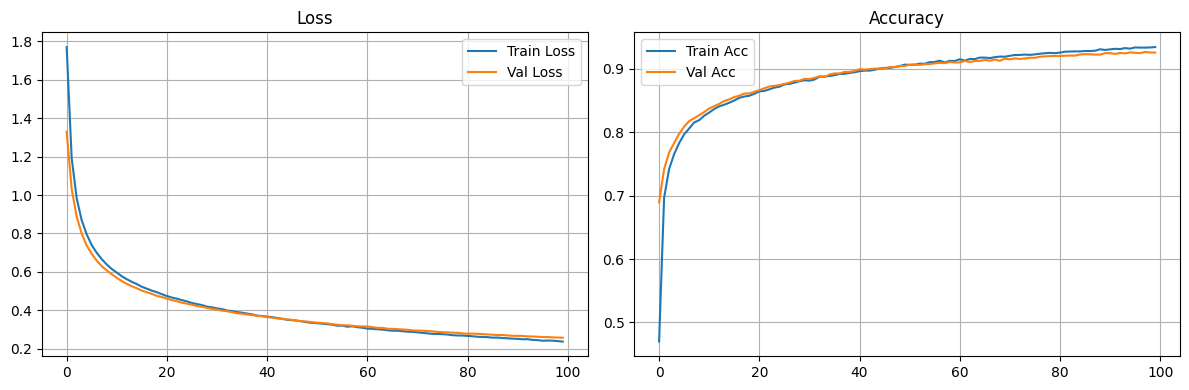

In [13]:

history = trainer.history

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"],   label="Val Loss")
plt.title("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"],   label="Val Acc")
plt.title("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()




Visualized the test (do change)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


🏆 Final Test Results: Loss: 0.5219 | Accuracy: 0.8408


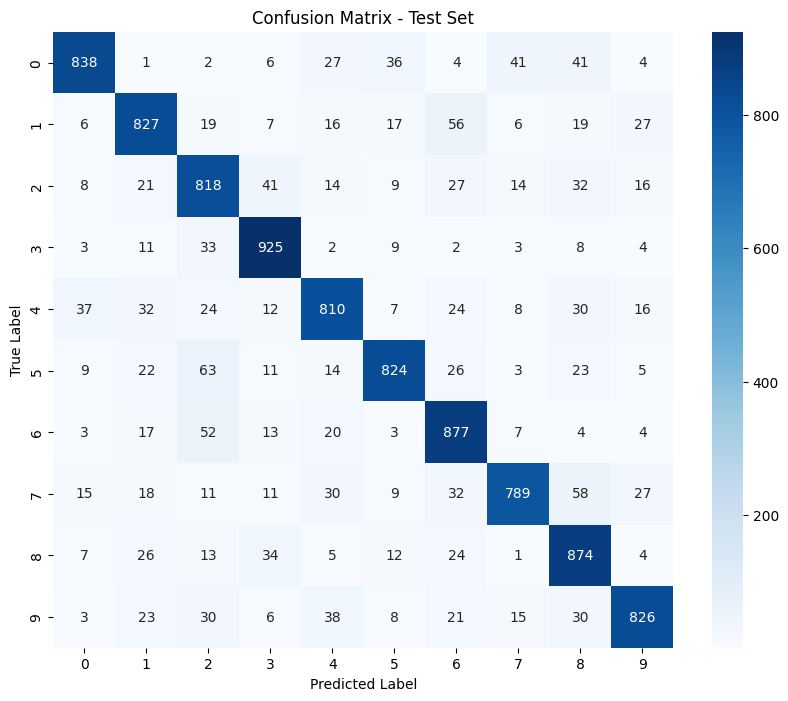


Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.9020    0.8380    0.8688      1000
           1     0.8287    0.8270    0.8278      1000
           2     0.7681    0.8180    0.7923      1000
           3     0.8677    0.9250    0.8955      1000
           4     0.8299    0.8100    0.8198      1000
           5     0.8822    0.8240    0.8521      1000
           6     0.8024    0.8770    0.8380      1000
           7     0.8895    0.7890    0.8362      1000
           8     0.7811    0.8740    0.8249      1000
           9     0.8853    0.8260    0.8546      1000

    accuracy                         0.8408     10000
   macro avg     0.8437    0.8408    0.8410     10000
weighted avg     0.8437    0.8408    0.8410     10000



In [14]:
import seaborn as sns

test_loss, test_acc = trainer.evaluate(test_loader)
print(f"🏆 Final Test Results: Loss: {test_loss:.4f} | Accuracy: {test_acc:.4f}")

preds, targets = trainer.predict_all(test_loader)

cm = confusion_matrix(targets, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# הדפסת דוח מפורט
print("\nDetailed Classification Report:")
print(classification_report(targets, preds, digits=4))